# Librerías

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from skforecast.ForecasterRnn import ForecasterRnn
from skforecast.ForecasterRnn.utils import create_and_compile_model
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
import warnings
import time
warnings.filterwarnings('ignore')

# ENTRENAMIENTO

## Carga de datos

In [66]:
df_raw = pd.read_csv("datos_preprocesados.csv", parse_dates=['fecha'], index_col='fecha')
df = df_raw.asfreq('D').copy()
df = df.sort_index()

## División del conjunto de datos

In [67]:
end_train = '2023-01-01'
end_validation = '2023-08-05'
df_train = df.loc[: end_train, :]
df_val   = df.loc[end_train:end_validation, :]
df_test  = df.loc[end_validation:, :]

print(f"Dates train      : {df_train.index.min()} --- {df_train.index.max()}  (n={len(df_train)})")
print(f"Dates validacion : {df_val.index.min()} --- {df_val.index.max()}  (n={len(df_val)})")
print(f"Dates test       : {df_test.index.min()} --- {df_test.index.max()}  (n={len(df_test)})")

Dates train      : 2019-01-01 00:00:00 --- 2023-01-01 00:00:00  (n=1462)
Dates validacion : 2023-01-01 00:00:00 --- 2023-08-05 00:00:00  (n=217)
Dates test       : 2023-08-05 00:00:00 --- 2024-09-26 00:00:00  (n=419)


## Modelo LSTM

In [62]:
series = ['demanda', 'diasem', 'trim', 'festivo', 'tmed', 'hrmed']
levels = ['demanda']
lags = 7
steps = 1

data = df[series].copy()
data_train = df_train[series].copy()
data_val = df_val[series].copy()
data_test=df_test[series].copy()


def RNN(recurrent_units, dense_units, learning_rate, epochs, batch_size):
    # Crear el modelo RNN directamente dentro del forecaster
    model = create_and_compile_model(
        series=data_train,
        levels=levels, 
        lags=lags,
        steps=steps,
        recurrent_layer="LSTM",
        recurrent_units=recurrent_units,
        dense_units=dense_units,
        optimizer=Adam(learning_rate=learning_rate), 
        loss=MeanSquaredError()
    )

    # Crear el forecaster
    forecaster = ForecasterRnn(
        regressor=model,
        levels=levels,
        steps=steps,
        lags=lags,
        transformer_series=MinMaxScaler(),
        fit_kwargs={
            "epochs": epochs,  # Ajusta según sea necesario
            "batch_size": batch_size,
            "series_val": data_val,
        },
    )

    # Fit forecaster
    # ==============================================================================
    forecaster.fit(data_train)

    # Training and overfitting tracking
    # ==============================================================================
    fig, ax = plt.subplots(figsize=(7, 3))
    forecaster.plot_history(ax=ax)

    # Configura para que se muestren las etiquetas cada dos elementos
    labels = ax.get_xticks()  # Obtiene todas las posiciones de las etiquetas en el eje x
    ax.set_xticks(labels[::2])  # Selecciona cada segunda etiqueta

    # Títulos y etiquetas de los ejes
    ax.set_title("Pérdida de Entrenamiento y Validación")
    ax.set_xlabel("Número de épocas")
    ax.set_ylabel("Pérdida")

    plt.tight_layout()  # Ajusta el diseño para que las etiquetas no se corten
    plt.show()

    
    # Backtesting with test data
    # ==============================================================================
    metrics, predictions = backtesting_forecaster_multiseries(
        forecaster=forecaster,
        steps=forecaster.max_step,
        series=data,
        levels=forecaster.levels,
        initial_train_size=len(data.loc[:end_validation, :]), # Datos de entrenamiento + validación
        metric="mean_absolute_error",
        verbose=False,
        refit=False,
    )
    return metrics, predictions

## Resultados de modelo LSTM

Testing combination: recurrent_units=110, dense_units=110, learning_rate=0.011, epochs=45, batch_size=8
keras version: 3.6.0
Using backend: tensorflow
tensorflow version: 2.18.0
Epoch 1/45
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0966 - val_loss: 0.0252
Epoch 2/45
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0163 - val_loss: 0.0172
Epoch 3/45
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0106 - val_loss: 0.0090
Epoch 4/45
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0060 - val_loss: 0.0121
Epoch 5/45
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0063 - val_loss: 0.0096
Epoch 6/45
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - val_loss: 0.0092
Epoch 7/45
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0066 - val_loss: 0.0071
Epoch 8/45
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0068 - val_loss: 0.0077
Epoch 9/45
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0050 - val_loss: 0.0082
Epoch 10/45
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/

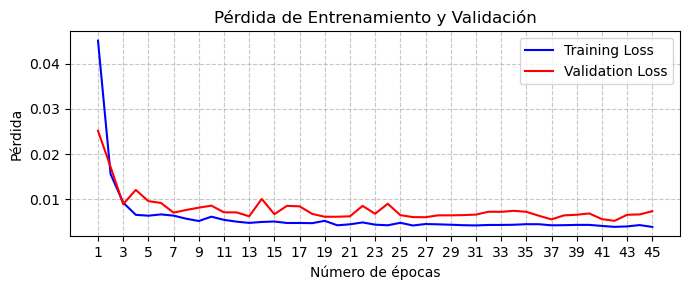

Epoch 1/45
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0035 - val_loss: 0.0055
Epoch 2/45
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0042 - val_loss: 0.0054
Epoch 3/45
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0042 - val_loss: 0.0060
Epoch 4/45
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0040 - val_loss: 0.0061
Epoch 5/45
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0042 - val_loss: 0.0058
Epoch 6/45
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0038 - val_loss: 0.0056
Epoch 7/45
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0040 - val_loss: 0.0059
Epoch 8/45
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0037 - val_loss: 0.0050
Epoch 9/45
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0041 - val_loss: 0.0076
Epoch 10/45
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0039 - val_loss: 0.0065
Epoch 11/45
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0036 - val_loss: 0.0064
Epoch 12/45
209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

  0%|          | 0/418 [00:00<?, ?it/s]

Tiempo de ejecución: 85.16 segundos

Mejores hiperparámetros encontrados:
recurrent_units                                                  110
dense_units                                                      110
learning_rate                                                  0.011
epochs                                                            45
batch_size                                                         8
MAE                                                       701.896316
predictions                         demanda
2023-08-06  23076.974...
Name: 0, dtype: object


In [64]:
# Definir el espacio de búsqueda de hiperparámetros
# param_grid = {
#     'recurrent_units': [100, 110],
#     'dense_units': [90, 110, 100],
#     'learning_rate': [0.0115, 0.011],
#     'epochs': [40, 45],
#     'batch_size': [8],
# }

param_grid = {
    'recurrent_units': [110],
    'dense_units': [110],
    'learning_rate': [ 0.011],
    'epochs': [45],
    'batch_size': [8],
}


# Almacenar los resultados
results = []

start_time = time.time()

# Realizar el grid search manual
for recurrent_units in param_grid['recurrent_units']:
    for dense_units in param_grid['dense_units']:
        for learning_rate in param_grid['learning_rate']:
            for epochs in param_grid['epochs']:
                for batch_size in param_grid['batch_size']:
                    # Imprimir la combinación de hiperparámetros
                    print(f'Testing combination: recurrent_units={recurrent_units}, dense_units={dense_units}, '
                          f'learning_rate={learning_rate}, epochs={epochs}, batch_size={batch_size}')
                    
                    results_model = RNN(recurrent_units, dense_units, learning_rate, epochs, batch_size)

                    # Guardar los resultados y las predicciones
                    results.append({
                        'recurrent_units': recurrent_units,
                        'dense_units': dense_units,
                        'learning_rate': learning_rate,
                        'epochs': epochs,
                        'batch_size': batch_size,
                        'MAE': results_model[0]['mean_absolute_error'][0],  # Supongamos que 'metrics' contiene el MAE
                        'predictions': results_model[1]  # Guarda las predicciones
                    })

# Convertir los resultados a un DataFrame
results_df = pd.DataFrame(results)

# Obtener el mejor resultado
best_result_index = results_df['MAE'].idxmin()  # Encuentra el índice del mejor MAE
mejor_result = results_df.loc[best_result_index]  # Obtiene el mejor resultado

end_time = time.time() - start_time

# Imprimir el mejor resultado
print(f'Tiempo de ejecución: {end_time:.2f} segundos')
print("\nMejores hiperparámetros encontrados:")
print(mejor_result)


In [ ]:
mejor_result

## Representación gráfica de los resultados

In [ ]:
# Guardar las predicciones del mejor resultado
best_predictions = mejor_result['predictions']
predictions = best_predictions

plt.figure(figsize=(10, 5))  # Define el tamaño de la figura
plt.plot(data_test.index, data_test['demanda'], label="Real Value", color='orange', linestyle='-') # Valores reales
plt.plot(predictions.index, predictions, label="Predictions", color='blue', linestyle='--') # Valores predichos


# Configurar el título y las etiquetas
#plt.title("Real Value vs Predicted in Test Data")
plt.xlabel("Tiempo", fontsize=14, labelpad=15)
plt.ylabel('Demanda eléctrica (MW)', labelpad=15, fontsize=14)

# Añadir leyenda
plt.legend(loc='upper left')

# Mostrar el gráfico
plt.grid()  # Añadir cuadrícula para mejor visualización
plt.tight_layout()  # Ajustar el layout
plt.show()
